In [1]:
import  glob
import  fitsio
import  redrock.templates

import  pylab                  as      pl
import  numpy                  as      np
import  matplotlib.pyplot      as      plt
import  astropy.io.fits        as      fits

from    astropy.table          import  Table, join
from    astropy.coordinates    import  SkyCoord
from    astropy                import  units as u
from    desitarget.cmx         import  cmx_targetmask
from    desitarget             import  targetmask
from    desispec.interpolation import  resample_flux
from    desispec.resolution    import  Resolution
from    desispec.specscore     import  compute_frame_scores

In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

In [3]:
root  = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/'

## Prep. redrock templates

In [4]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## GET GAMA G12 TRUTH TABLES

In [5]:
GAMA  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/GAMA-DR3-SpecObj-match.fits')
LGAMA = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits')

In [6]:
# Table(LGAMA)

In [7]:
# Table(GAMA)

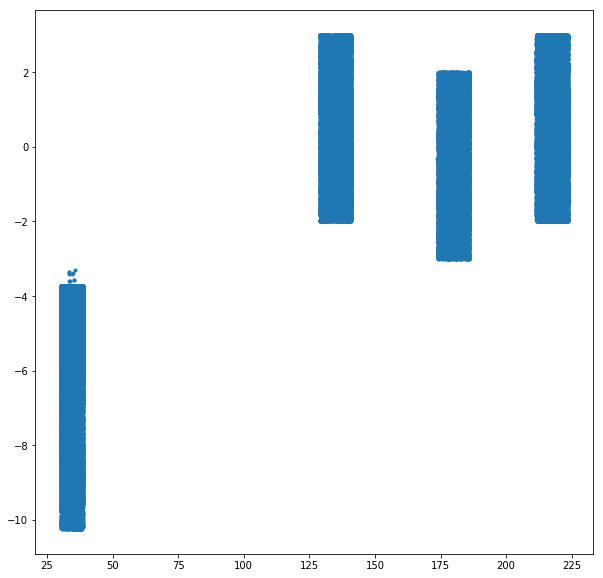

In [8]:
pl.plot(GAMA['RA'], GAMA['DEC'], '.')

In [9]:
##  Restrict to G12
isin   = (GAMA['RA'] < 200.) & (GAMA['RA'] > 150.)

G12    =  GAMA[isin]
LG12   =  LGAMA[isin]

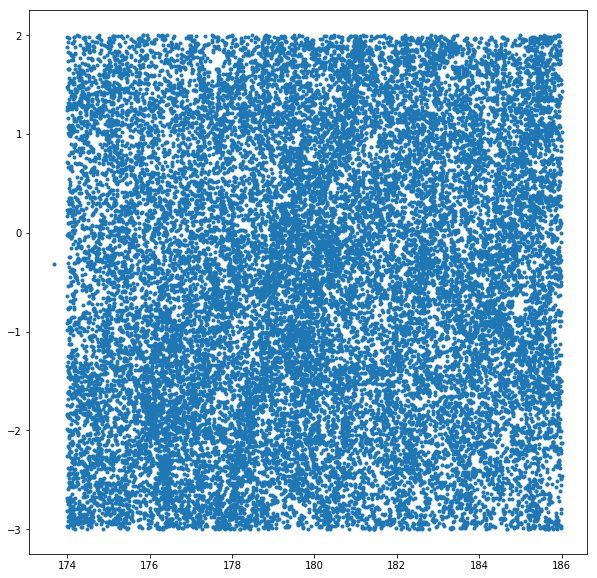

In [10]:
pl.plot(G12['RA'], G12['DEC'], '.')

In [11]:
##  GET SDSS redshifts  

In [12]:
SDSS  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/sdss-specObj-dr14-unique-trimmed-match.fits')
LSDSS = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-sdss-specObj-dr14-unique-trimmed-match.fits')

##  Relevant exposure IDS 

In [13]:
# ALL EXPIDS
expids = glob.glob('/global/cfs/cdirs/desi/spectro/redux/daily/exposures/20200225/*')
expids = [x.split('/')[-1] for x in expids]

In [14]:
# BGS EXPIDS
bgs_expids = ['00052112', '00052113', '00052114', '00052115', '00052116'] 

In [15]:
# E.g.  /global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-b0-00052090.fits
cframes     = {}

for expid in bgs_expids:    
  cframes[expid] = {}

  ##  Fluxes 
  cframes[expid]['b'] = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-b0-{}.fits'.format(expid), ext=0)
  cframes[expid]['r'] = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-r0-{}.fits'.format(expid), ext=0) 
  cframes[expid]['z'] = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-z0-{}.fits'.format(expid), ext=0) 

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

In [16]:
# Coordinates
# ls /global/cfs/cdirs/desi/spectro/data/20200225/*/coordinates-*
fp    = {}
fas   = {}
coors = {}

for _ in bgs_expids:
  coors[_] = fitsio.read('/global/cfs/cdirs/desi/spectro/data/20200225/{}/coordinates-{}.fits'.format(_,_))

  fas[_]   = fitsio.read('/global/cfs/cdirs/desi/spectro/data/20200225/{}/fiberassign-070502.fits'.format(_))
    
  fp[_]    = join(Table(fas[_]), Table(coors[_]), keys=['TARGET_RA', 'TARGET_DEC'])
  fp[_].sort('TARGETID')

In [17]:
# Difference is the GFAs.
len(fas['00052112']), len(coors['00052112'])

(5000, 5126)

In [18]:
# https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags
Table(coors['00052112'])[:10]

PETAL_LOC,DEVICE_LOC,CONVERGED,TARGET_RA,TARGET_DEC,FIBERASSIGN_X,FIBERASSIGN_Y,REQ_Q,REQ_S,REQ_X,REQ_Y,EXP_Q_0,EXP_S_0,FLAGS_EXP_0,EXP_X_0,EXP_Y_0,FVC_X_0,FVC_Y_0,FLAGS_FVC_0,CNT_X_0,CNT_Y_0,FLAGS_CNT_0,CNT_MAG_0,CNT_ERR_0,DX_0,DY_0,FPA_X_0,FPA_Y_0,FLAGS_COR_0,REQ_X_0,REQ_Y_0,OFFSET_0,EXP_Q_1,EXP_S_1,FLAGS_EXP_1,EXP_X_1,EXP_Y_1,FVC_X_1,FVC_Y_1,FLAGS_FVC_1,CNT_X_1,CNT_Y_1,FLAGS_CNT_1,CNT_MAG_1,CNT_ERR_1,DX_1,DY_1,FPA_X_1,FPA_Y_1,FLAGS_COR_1,REQ_X_1,REQ_Y_1,OFFSET_1,EXP_Q_2,EXP_S_2,FLAGS_EXP_2,EXP_X_2,EXP_Y_2,FVC_X_2,FVC_Y_2,FLAGS_FVC_2,CNT_X_2,CNT_Y_2,FLAGS_CNT_2,CNT_MAG_2,CNT_ERR_2,DX_2,DY_2,FPA_X_2,FPA_Y_2,FLAGS_COR_2,REQ_X_2,REQ_Y_2,OFFSET_2
int64,int64,int64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,0,0,180.00335405788294,-0.621495582398852,-0.8161547,-29.559782,268.433,29.5122,-0.807,-29.501,-91.56700482678802,29.51219500358265,4,-0.8070352584048036,-29.500984248411754,-32.748,-128.427,4,-59.96300000000019,-140.24800000000005,69,12.591,0.001,0.015,-0.027,-0.822,-29.506,69,-0.8069999999999999,-29.533,0.030886890422961,-91.56524613771153,29.544195983155205,4,-0.8070038284804425,-29.532997469859243,-32.75,-128.656,4,-59.88599999999997,-140.56100000000015,69,12.577,0.001,-0.012,-0.001,-0.8,-29.534,69,-0.812,-29.535,0.012041594578792296,-91.57482354534343,29.546339324256955,4,-0.8119993762986774,-29.535004653638484,-32.714,-128.671,4,-59.746999999999844,-140.4920000000002,69,12.584,0.001,0.012,0.01,-0.816,-29.535,69,-0.8039999999999999,-29.525,0.015620499351813309
0,1,0,180.0231341950373,-0.6507315506445961,-5.6288614,-36.67601,261.285,37.0345,-5.612,-36.607,-98.7149953887083,37.034501344861596,4,-5.611397695467422,-36.6065698348362,1.273,-179.515,4,-25.923999999999978,-191.288,69,12.634,0.001,0.011,-0.03,-5.625,-36.61,69,-5.614,-36.64,0.03195309061734092,-98.71115036179455,37.06794462446719,4,-5.614006023842825,-36.64000288491379,1.29,-179.755,4,-25.824999999999818,-191.5949999999998,69,12.661,0.001,-0.012,-0.005,-5.605,-36.637,69,-5.617,-36.642,0.013000000000000001,-98.71525523655997,37.07037515938638,4,-5.616999304401997,-36.64200298650849,1.312,-179.769,4,-25.69399999999996,-191.5540000000001,69,12.639,0.001,0.011,0.009,-5.62,-36.642,69,-5.609,-36.633,0.014212670403551895
0,2,0,179.98077758344465,-0.6404921089237555,4.6765695,-34.18345,277.805,34.438,4.677,-34.119,-82.19501441928672,34.43800188244677,4,4.676704446560656,-34.11869512226655,-72.248,-161.18,4,-99.39699999999993,-173.08199999999988,69,12.613,0.001,0.021,-0.02,4.657,-34.132,69,4.678,-34.152,0.029,-82.20039154731428,34.47117524482999,4,4.678004238925492,-34.15199951756062,-72.259,-161.419,4,-99.36400000000003,-173.3159999999998,69,12.707,0.001,-0.012,-0.005,4.686,-34.148,69,4.674,-34.153000000000006,0.013000000000000001,-82.20720975790012,34.47162141788797,4,4.674000605712774,-34.15299800079695,-72.23,-161.426,4,-99.23799999999983,-173.2779999999998,69,12.622,0.001,0.011,0.009,4.671,-34.153,69,4.682,-34.144,0.014212670403551895
0,3,0,180.03445477650894,-0.7029945365211852,-8.385128,-49.404007,260.375,50.0225,-8.363,-49.318,-99.62499880318101,50.02250549837621,4,-8.363566359348193,-49.31750361890276,20.294,-270.542,4,-6.80600000000004,-282.3879999999999,69,12.585,0.001,0.016,-0.019,-8.382,-49.336,69,-8.366,-49.355,0.02483948469674844,-99.62056926901467,50.05988582029831,4,-8.366000374457617,-49.35500274069925,20.309,-270.81,4,-6.719000000000051,-282.6080000000002,69,12.599,0.001,-0.01,-0.006,-8.36,-49.35,69,-8.37,-49.356,0.0116619037896906,-99.62488429242188,50.0615384

In [19]:
Table(fas['00052112'])[:10]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int32,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64
35185718485585996,0,311,311,0,0,179.66987727167816,-1.6574385652529624,-7.681228,-3.264253,2.0258374,14.280712,2015.5,5400.0,545,1,TGT,82.18579,-288.26108,0,1000,0.232311560519591,65535,99,8000,321006,1796m017,4172,PSF,168177040000000.0,740727440000000.0,0.027289713,10.051535,35.056255,83.256966,684.63086,257.76917,57.142536,0.92239374,0.94703734,0.9700204,1.8116782e-05,1.7769367e-05,2.4871695e-05,0.12890169,0.073827125,0.017526086,0.9999997,0.99999964,0.75029933,4,5,3,1706.1888,682.32404,106.09397,1119.082,458.38928,69.090546,45.279636,25.168295,-3.0709102,-47.548084,2.5921524,0.42923066,0.00072050566,1.0495133e-05,0.9953859,0.9971638,0.9993944,0.9997713,0,0,0,7.8127766,27.248247,64.71331,7.8127766,27.248247,64.71331,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3602417082379287808,G2,18.712095,464.9532,19.628769,26.29529,17.708935,99.5623,1.3883798,0.35110453,False,0.629642,True,1.0867026,11.4330635,S,545,2463,1,25596,0.0,0.0,0.0,0.0,0,0,0
35185724529574460,0,272,272,1,0,179.75523346985221,-1.599430718530176,0.0,0.0,0.0,0.0,2015.5,5400.0,72057594037928192,1,TGT,60.752766,-272.98505,0,5000,0.4936894968225848,65535,99,8000,322447,1798m015,572,DEV,1351837500000.0,5213159700000.0,0.027733779,18.261003,59.709057,115.76403,311.15115,145.66374,32.562695,0.92118204,0.9461991,0.96954006,0.0011055123,0.001216456,0.00082549226,0.00057909294,0.0007289197,0.00094134087,0.9999999,1.0,0.9999999,4,6,4,1760.4818,807.0957,151.27748,1135.8314,542.3

In [20]:
# Good fiber across exposures.
tids = []

for _ in fp.keys():
    tids += list(fp[_]['TARGETID'])

In [21]:
tids   = np.unique(tids)
isgood = np.ones_like(tids)

In [22]:
for _ in fp.keys():
    # End of positioning sequence, look for largest FLAGS_EXP_N.
    
    isgood = isgood & (fp[_]['FLAGS_EXP_2'] == 4)

##  NUMBER OF FIBER REACH ERRORS FOR ALL TARGETS ON PLATE

In [23]:
np.count_nonzero(isgood), len(tids)

(3873, 5000)

##   GET COADDED EXPOSURES AND ZBEST FILES

In [30]:
coadds      = {}
zbests      = {}

coadds_wave = {}
coadds_flux = {}
coadds_res  = {}
coadds_ivar = {}
coadds_mask = {}

coadds_bsnr = {}
coadds_rsnr = {}
coadds_zsnr = {}

In [25]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_FLUX'           / extension name                                 
# BUNIT   = '10**-17 erg/(s cm2 Angstrom)'                                        
# CHECKSUM= '1gAq4f6n1fAn1f3n'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '1442897442'         / data unit checksum updated 2020-02-26T06:51:09 

In [26]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_IVAR'           / extension name                                 
# BUNIT   = '10**+34 (s2 cm4 Angstrom2) / erg2'                                   
# CHECKSUM= '4aSk6XPj4aPj4WPj'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '966772586'          / data unit checksum updated 2020-02-26T06:51:09 

In [ ]:
bandpasses              = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}
petals                  = [0,3,6,7,9]

for petal in [0]:
    ##  FIBER MAPS
    coadds[petal]       = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal))    
    zbests[petal]       = fitsio.read(root + 'zbest-{}-70502-20200225.fits'.format(petal))
    
    coadds_wave[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=2)
    coadds_flux[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=3) 
    coadds_ivar[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=4)
    coadds_mask[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=5)
    coadds_res[petal]   = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=6) 

    mask                = coadds_mask[petal]

    wave                = coadds_wave[petal]
    dwave               = np.gradient(wave)

    bmask               = mask & (wave >= bandpasses['b'][0]) & (wave <= bandpasses['b'][1]) 
    rmask               = mask & (wave >= bandpasses['r'][0]) & (wave <= bandpasses['r'][1]) 
    zmask               = mask & (wave >= bandpasses['z'][0]) & (wave <= bandpasses['z'][1]) 
    
    # https://github.com/desihub/desispec/blob/c544749a8ab4b982a054b91247f056c2ce4bd8ce/py/desispec/specscore.py#L148    
    coadds_bsnr[petal]  = coadds_flux[petal][:,bmask] * np.sqrt(coadds_ivar[petal][:, bmask]) / np.sqrt(dwave[bmask])
    coadds_rsnr[petal]  = coadds_flux[petal][:,rmask] * np.sqrt(coadds_ivar[petal][:, rmask]) / np.sqrt(dwave[rmask])
    coadds_zsnr[petal]  = coadds_flux[petal][:,zmask] * np.sqrt(coadds_ivar[petal][:, zmask]) / np.sqrt(dwave[zmask])

In [ ]:
##  Assumes similar across exposures. 
wave           = coadds_wave[0]

acoadds_flux   = np.vstack((coadds_flux[0], coadds_flux[3], coadds_flux[6], coadds_flux[7], coadds_flux[9]))
acoadds_bsnr   = np.vstack((coadds_bsnr[0], coadds_bsnr[3], coadds_bsnr[6], coadds_bsnr[7], coadds_snr[9]))
acoadds_res    = np.vstack((coadds_res[0], coadds_res[3], coadds_res[6], coadds_res[7], coadds_res[9]))

acoadds        = np.hstack((coadds[0], coadds[3], coadds[6], coadds[7], coadds[9]))
azbests        = np.hstack((zbests[0], zbests[3], zbests[6], zbests[7], zbests[9]))

##  Sort COADDS by TARGETID and keep those with NO FIBER REACH ERROR.

In [ ]:
inds           = np.argsort(acoadds['TARGETID'])

In [ ]:
acoadds        = acoadds[inds]
azbests        = azbests[inds]

In [ ]:
assert  len(acoadds) == len(azbests)

In [ ]:
len(acoadds['TARGETID'])

In [ ]:
in_coadd       = [x in acoadds['TARGETID'] for x in tids]

In [ ]:
np.count_nonzero(in_coadd), np.count_nonzero(isgood[in_coadd])

In [ ]:
tids           =   tids[in_coadd]
isgood         = isgood[in_coadd]

In [ ]:
len(tids), len(azbests), len(acoadds), np.count_nonzero(isgood)

In [ ]:
assert  np.all(tids == acoadds['TARGETID'])

##  Keep BGS targets only, distinguishing between MAIN_BRIGHT and SV0 

In [ ]:
IS_MSV_BRIGHT  = (acoadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
IS_SV0         = (acoadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

IS_BGS         = IS_MSV_BRIGHT | IS_SV0 
IS_GOOD_BGS    = IS_BGS & isgood

IS_GOOD_BGS    = IS_GOOD_BGS.astype(bool)

IS_MSV_BRIGHT  = IS_MSV_BRIGHT[IS_GOOD_BGS]
IS_SV0         =        IS_SV0[IS_GOOD_BGS]

In [ ]:
np.count_nonzero(IS_BGS), np.count_nonzero(IS_GOOD_BGS), np.count_nonzero(IS_MSV_BRIGHT), np.count_nonzero(IS_SV0)

In [ ]:
IS_GOOD_BGS, len(IS_GOOD_BGS)

In [ ]:
bgs_acoadds      = acoadds[IS_GOOD_BGS]
bgs_azbests      = azbests[IS_GOOD_BGS]
bgs_acoadds_res  = acoadds_res[IS_GOOD_BGS]
bgs_acoadds_flux = acoadds_flux[IS_GOOD_BGS]

In [ ]:
len(bgs_acoadds), len(bgs_azbests)

In [ ]:
bgs_azbests = Table(bgs_azbests)

bgs_azbests['IS_SV0'] = IS_SV0
bgs_azbests['IS_MSV_BRIGHT'] = IS_MSV_BRIGHT

In [ ]:
len(bgs_azbests), np.count_nonzero(bgs_azbests['ZWARN'] > 0)

In [ ]:
bgs_acoadds = Table(bgs_acoadds)

bgs_acoadds['IS_SV0'] = IS_SV0
bgs_acoadds['IS_MSV_BRIGHT'] = IS_MSV_BRIGHT

In [ ]:
pl.plot(bgs_acoadds['TARGET_RA'][IS_SV0],        bgs_acoadds['TARGET_DEC'][IS_SV0], '.', c='gold', label='SV0')
pl.plot(bgs_acoadds['TARGET_RA'][IS_MSV_BRIGHT], bgs_acoadds['TARGET_DEC'][IS_MSV_BRIGHT], '.', c='r', label='Main Bright')

pl.legend(loc=2, frameon=False, fontsize=16)

##  Example of coadded flux

In [ ]:
def bestfit_compare(i, ax, zbests, coadds_flux):
    zbest    = Table(zbests)[i]
    # res    = coadds_res[i]

    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()

    fulltype = (spectype, subtype)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    # R      = Resolution(res)
    # txflux = R.dot(resample_flux(wave, twave, tflux))
    
    ax.plot(wave, coadds_flux[i,:], lw=1.0, label='z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(z, zerr, zwarn, spectype, subtype, dchi2))
    ax.plot(twave,            tflux, lw=1.0)
    # ax.plot( wave,            txflux, lw=1.0)

    ax.legend(loc=2)
    
    ax.set_xlim(3500., 10000.)
    ax.set_ylim(bottom = -2.5)

In [ ]:
nspec     = 10
fig, axes = plt.subplots(nspec, figsize=(20, 50))

best      = np.argsort(bgs_azbests['DELTACHI2'])[::-1]
isin      = bgs_azbests['DELTACHI2'][best] < 100.

for i in range(10):
  bestfit_compare(i, axes[i], bgs_azbests[best][isin], bgs_acoadds_flux[best][isin])

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
pl.hist(bgs_azbests['DELTACHI2'], bins=np.arange(0., 5000., 100.))

##  Parameter determining redshift accuracy best 

In [ ]:
len(bgs_azbests['DELTACHI2'])

##  Match to G12

In [ ]:
# Matching
c              = SkyCoord(ra=bgs_acoadds['TARGET_RA']*u.degree, dec=bgs_acoadds['TARGET_DEC']*u.degree)
catalog        = SkyCoord(ra=G12['RA']*u.degree, dec=G12['DEC']*u.degree)

idx, d2d, d3d  = c.match_to_catalog_sky(catalog)

max_sep        = 1.0 * u.arcsec

sep_constraint = d2d < max_sep

c              = c[sep_constraint]

_matches       = catalog[idx[sep_constraint]]

gcoadd_matches = bgs_acoadds[sep_constraint]
gzbest_matches = bgs_azbests[sep_constraint] 
gama_matches   =     G12[idx[sep_constraint]]

In [ ]:
# zbest_matches

In [ ]:
# Sanity check
dra, ddec     = c.spherical_offsets_to(_matches)

In [ ]:
#dra.arcsec, ddec.arcsec

In [ ]:
_ = np.arange(0.0, 1.0, 0.1)

pl.plot(_, _, 'k-', lw=0.1)

pl.plot(gama_matches['Z'][gzbest_matches['IS_SV0'] == True],        gzbest_matches['Z'][gzbest_matches['IS_SV0'] == True], '.', c='r')
pl.plot(gama_matches['Z'][gzbest_matches['IS_MSV_BRIGHT'] == True], gzbest_matches['Z'][gzbest_matches['IS_MSV_BRIGHT'] == True], '.', c='g')

pl.xlabel('G12 $z$', fontsize=12)
pl.ylabel('rr $z$', fontsize=12) 

In [ ]:
len(gzbest_matches)

In [ ]:
# pl.hist(gzbest_matches['Z'], bins=25)

In [ ]:
# pl.hist(gama_matches['Z'] - gzbest_matches['Z'], bins=np.arange(-2.0, 2.0, 0.1))
# pl.xlim(-1., 1.)

In [ ]:
badz           = gzbest_matches['Z'] > 1.0

bcoadd_matches = bgs_acoadds_flux[sep_constraint][badz]
bzbest_matches =      bgs_azbests[sep_constraint][badz]

nspec          = len(bzbest_matches)
fig, axes      = plt.subplots(nspec, figsize=(20, 90))

for i in range(nspec):
  bestfit_compare(i, axes[i], bzbest_matches, bcoadd_matches)

for ax in fig.get_axes():
    ax.label_outer()

##  Match to SDSS

In [ ]:
# Table(SDSS)

In [ ]:
# Matching
c              = SkyCoord(ra=bgs_acoadds['TARGET_RA']*u.degree, dec=bgs_acoadds['TARGET_DEC']*u.degree)
catalog        = SkyCoord(ra=SDSS['PLUG_RA']*u.degree, dec=SDSS['PLUG_DEC']*u.degree)

idx, d2d, d3d  = c.match_to_catalog_sky(catalog)

max_sep        = 1.0 * u.arcsec

sep_constraint = d2d < max_sep

c              = c[sep_constraint]

_matches       = catalog[idx[sep_constraint]]

scoadd_matches = bgs_acoadds[sep_constraint]
szbest_matches = bgs_azbests[sep_constraint]

sdss_matches   =     SDSS[idx[sep_constraint]]

In [ ]:
_              = np.arange(0.0, 1.0, 0.1)

pl.plot(_, _, 'k-', lw=0.1)

pl.plot(sdss_matches['Z'][szbest_matches['IS_SV0'] == True],        szbest_matches['Z'][szbest_matches['IS_SV0'] == True], '.', c='r')
pl.plot(sdss_matches['Z'][szbest_matches['IS_MSV_BRIGHT'] == True], szbest_matches['Z'][szbest_matches['IS_MSV_BRIGHT'] == True], '.', c='g')

pl.xlabel('SDSS $z$', fontsize=12)
pl.ylabel('rr $z$', fontsize=12)

In [ ]:
##  os.system('http://legacysurvey.org/viewer/cutout.fits?ra=186.3882&dec=12.2592&layer=dr8&pixscale=1.00']

In [ ]:
##  Table(sdss_matches)

##  Bad zs in SDSS comparison (rr z > 1.0)

In [ ]:
badz           = szbest_matches['Z'] > 1.0

bcoadd_matches = bgs_acoadds_flux[sep_constraint][badz]
bzbest_matches =      bgs_azbests[sep_constraint][badz]

nspec          = len(bzbest_matches)
fig, axes      = plt.subplots(nspec, figsize=(20, 50))

for i in range(nspec):
  bestfit_compare(i, axes[i], bzbest_matches, bcoadd_matches)

for ax in fig.get_axes():
    ax.label_outer()

##  Done.